Clinical, Cognitive, Demographic Pipeline


In [1]:
import re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


VISIT_PRIORITY = {
    "bl": 1, "init": 1,
    "sc": 2, "screening": 2,
    "m03": 3, "month3": 3, "3m": 3,
    "m06": 4, "month6": 4, "6m": 4,
    "m12": 5, "month12": 5, "12m": 5,
    "m24": 6, "month24": 6, "24m": 6,
}

#  column mappings 
GENDER_MAP = {1: "male", 2: "female", "1": "male", "2": "female"}
DIAG_MAP   = {1: "CN",   2: "MCI",    3: "DEMENTIA", "1": "CN", "2": "MCI", "3": "DEMENTIA"}

#  column finder tokens
PTID_TOKENS   = ["ptid", "subjectid", "subject_id", "participantid", "participant_id"]
VISIT_TOKENS  = ["visit", "visist", "viscode", "viscode2"]
GENDER_TOKENS = ["gender"]
DIAG_TOKENS   = ["diagnosis", "diagnoses", "diag"]
AGE_TOKENS    = ["entry_age", "age", "ptage", "baselineage"]

MMSE_TOKENS   = ["mmscore", "mmse"]
CDRSB_TOKENS  = ["cdr sum of boxes", "cdrsb"]
FAQ_TOKENS    = ["faq total", "faq total score", "faq"]
ADAS_TOKENS   = ["adas13", "adas 13"]
COMORB_TOKENS = ["hypertension", "stroke", "smok", "diabet", "cardio", "t2dm"]

#  normalise columns
def normalize_colnames(cols):
    def norm(c):
        c2 = str(c).strip()
        c2 = re.sub(r"\s+", " ", c2)
        return c2
    return [norm(c) for c in cols]

def find_exact_col(df, candidate_keys):
    for c in df.columns:
        lc = c.lower().replace(" ", "")
        for cand in candidate_keys:
            if lc == cand:
                return c
    return None

def find_contains_col(df, token_list):
    for col in df.columns:
        lc = col.lower()
        for tok in token_list:
            if tok in lc:
                return col
    return None

def parse_visit_priority(raw):
    if pd.isna(raw):
        return 10_000
    s = str(raw).strip().lower().replace(" ", "")
    if s in VISIT_PRIORITY:
        return VISIT_PRIORITY[s]
    m = re.match(r"m(\d+)", s)
    if m:
        try:
            months = int(m.group(1))
            base = 7
            return base + months
        except Exception:
            return 10_000
    v = re.match(r"v(\d+)", s)
    if v:
        return 9_000 + int(v.group(1))
    return 10_000

def drop_empty_columns(df: pd.DataFrame, keep_cols=None, min_non_null=1):
    keep_cols = [k for k in (keep_cols or []) if k is not None]
    drop = [c for c in df.columns if c not in keep_cols and df[c].notna().sum() < min_non_null]
    return df.drop(columns=drop), drop

# standardise columns
def standardize_yes_no(df: pd.DataFrame, yes_tokens=("y","yes","1"), no_tokens=("n","no","0")):
    out = df.copy()
    for c in out.columns:
        if out[c].dtype == object:
            lc = out[c].astype(str).str.strip().str.lower()
            mask_yes = lc.isin(yes_tokens)
            mask_no  = lc.isin(no_tokens)
            out.loc[mask_yes, c] = "Yes"
            out.loc[mask_no,  c] = "No"
    return out

def plot_bar_counts(series, title, out_png):
    plt.figure()
    series.value_counts(dropna=False).plot(kind="bar", title=title)
    plt.tight_layout()
    plt.savefig(out_png, dpi=150)
    plt.close()

def boxplot_by_diag(df, feat_col, diag_col, out_png):
    plt.figure()
    ok = False
    if feat_col and diag_col and df[feat_col].notna().sum() > 0:
        groups, labels = [], []
        for dlab in df[diag_col].dropna().unique():
            vals = pd.to_numeric(df.loc[df[diag_col] == dlab, feat_col], errors="coerce").dropna().values
            if len(vals) > 0:
                groups.append(vals); labels.append(str(dlab))
        if groups:
            plt.boxplot(groups, labels=labels)
            plt.title(f"{feat_col} by {diag_col}")
            plt.xlabel(diag_col); plt.ylabel(feat_col)
            ok = True
    if not ok:
        plt.title(f"{feat_col} by {diag_col} (no data)")
    plt.tight_layout(); plt.savefig(out_png, dpi=150); plt.close()

def missingness_heatmap(df, out_png):
    plt.figure(figsize=(8, 6))
    msk = df.isna()
    plt.imshow(msk.values, aspect="auto", interpolation="nearest")
    plt.title("Missingness heatmap (white = missing)")
    plt.xlabel("Columns"); plt.ylabel("Rows")
    plt.colorbar(); plt.tight_layout(); plt.savefig(out_png, dpi=150); plt.close()


In [2]:
from pathlib import Path
import pandas as pd
import os, glob

#  set path
PROJECT_ROOT = Path("/Users/madhurabn/Desktop/adni")

# input file 
INPUT_XLSX  = PROJECT_ROOT / "data" / "raw" / "dem_cli_cog ADNI.xlsx"

# outputs
OUTDIR      = PROJECT_ROOT / "data" / "processed"
PLOTSDIR    = OUTDIR / "plots"
OUTDIR.mkdir(parents=True, exist_ok=True)
PLOTSDIR.mkdir(parents=True, exist_ok=True)

print("CWD:", os.getcwd())
print("Project root:", PROJECT_ROOT)
print("Expecting input:", INPUT_XLSX)

# to check for input file 
if not INPUT_XLSX.exists():
    print("\nFile not found. Searching for candidates under data/raw ...")
    candidates = list((PROJECT_ROOT / "data" / "raw").rglob("*ADNI*.xlsx"))
    for i, p in enumerate(candidates, 1):
        print(f"{i}. {p}")
    if candidates:
        INPUT_XLSX = candidates[0]
        print("\nUsing first match:", INPUT_XLSX)
    else:
        raise FileNotFoundError("Could not find an ADNI .xlsx in data/raw/. Put your file there or update INPUT_XLSX.")

# read 
xl = pd.ExcelFile(INPUT_XLSX)
print("\nSheets:", xl.sheet_names)
df = xl.parse(xl.sheet_names[0])   # or xl.parse("Sheet1") if you prefer
print("Loaded shape:", df.shape)


input_path = INPUT_XLSX
outdir = OUTDIR
plots_dir = PLOTSDIR


CWD: /Users/madhurabn/Desktop/adni
Project root: /Users/madhurabn/Desktop/adni
Expecting input: /Users/madhurabn/Desktop/adni/data/raw/dem_cli_cog ADNI.xlsx

Sheets: ['Sheet1']


Loaded shape: (9561, 17)


In [3]:
# baseline-filter  
xl = pd.ExcelFile(input_path)
df = xl.parse(xl.sheet_names[0])
df.columns = normalize_colnames(df.columns)

ptid_col  = find_exact_col(df, PTID_TOKENS)
visit_col = find_exact_col(df, VISIT_TOKENS)
if ptid_col is None or visit_col is None:
    raise ValueError(f"Required columns not found. PTID={ptid_col}, VISIT={visit_col}\nGot: {list(df.columns)}")

gender_col = find_contains_col(df, GENDER_TOKENS)
diag_col   = find_contains_col(df, DIAG_TOKENS)
age_col    = find_contains_col(df, AGE_TOKENS)

# apply visit priority to keep earliest visit per PTID
work = df.copy()
work["_visit_priority"] = work[visit_col].apply(parse_visit_priority)
work_sorted = work.sort_values(by=["_visit_priority"]).copy()
baseline = work_sorted.drop_duplicates(subset=[ptid_col], keep="first").copy()
baseline.drop(columns=["_visit_priority"], inplace=True)

# light clean up
baseline, dropped_empty = drop_empty_columns(baseline, keep_cols=[ptid_col, visit_col, gender_col, diag_col])
baseline = standardize_yes_no(baseline)

# map codes
if gender_col:
    baseline[gender_col] = baseline[gender_col].map(lambda x: GENDER_MAP.get(x, x))
if diag_col:
    baseline[diag_col] = baseline[diag_col].map(lambda x: DIAG_MAP.get(x, x))

# drop empty Diagnosis rows
if diag_col is None:
    raise ValueError("Diagnosis column not detected. Merge/rename so a diagnosis-like column exists before this step.")

# drop empty diagnosis columns
baseline[diag_col] = baseline[diag_col].replace(["", " ", "NA", "N/A", "nan", "NaN"], pd.NA)
n_before = len(baseline)
baseline = baseline.dropna(subset=[diag_col]).copy()
n_after = len(baseline)
print(f"Dropped {n_before - n_after} rows with missing {diag_col}. Kept: {n_after}")

#  quick summary
print("\n Baseline (labeled) summary ")
print("Shape:", baseline.shape)

# overall missingness
total_missing = int(baseline.isna().sum().sum())
print("Total missing cells:", total_missing)

# top-10 columns by missing
miss_per_col = baseline.isna().sum().sort_values(ascending=False)
top_missing = miss_per_col[miss_per_col > 0].head(10)
if not top_missing.empty:
    print("\nTop missing columns:")
    print(top_missing)

# diagnosis distribution
vc_diag = baseline[diag_col].value_counts(dropna=False)
print("\nDiagnosis counts:")
print(vc_diag)
print("\nDiagnosis %:")
print((vc_diag / vc_diag.sum() * 100).round(1))

# gender distribution 
if gender_col:
    print("\nGender counts:")
    print(baseline[gender_col].value_counts(dropna=False))

# basic age statistics
if age_col:
    age_series = pd.to_numeric(baseline[age_col], errors="coerce")
    print("\nAge (numeric) describe:")
    print(age_series.describe())

# save baseline 
baseline_xlsx = outdir / "clinical_cognitive_demographic_baseline.xlsx"
baseline.to_excel(baseline_xlsx, index=False)
print("\nSaved labeled baseline:", baseline_xlsx)



Dropped 155 rows with missing DIAGNOSIS. Kept: 1205

 Baseline (labeled) summary 
Shape: (1205, 17)
Total missing cells: 9653

Top missing columns:
Cardiovascular disease history    1204
Stroke / TIA history              1204
Hypertension history              1204
Smoking history                   1204
Alcohol abuse history             1204
MMSCORE                           1200
education                         1200
CDR Sum of Boxes                  1200
FAQ Total Score                     18
Total Score (ADAS 13)               15
dtype: int64

Diagnosis counts:
DIAGNOSIS
MCI         585
CN          328
DEMENTIA    292
Name: count, dtype: int64

Diagnosis %:
DIAGNOSIS
MCI         48.5
CN          27.2
DEMENTIA    24.2
Name: count, dtype: float64

Gender counts:
gender
male      616
female    589
Name: count, dtype: int64

Age (numeric) describe:
count    1205.000000
mean       72.087710
std         7.164088
min        50.450000
25%        67.150000
50%        72.180000
75%        77.3

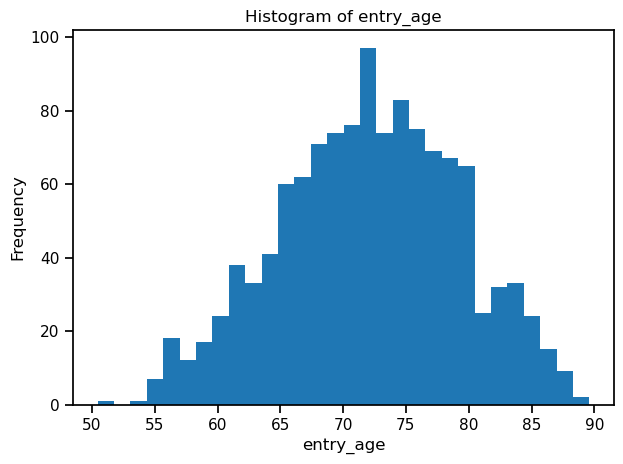

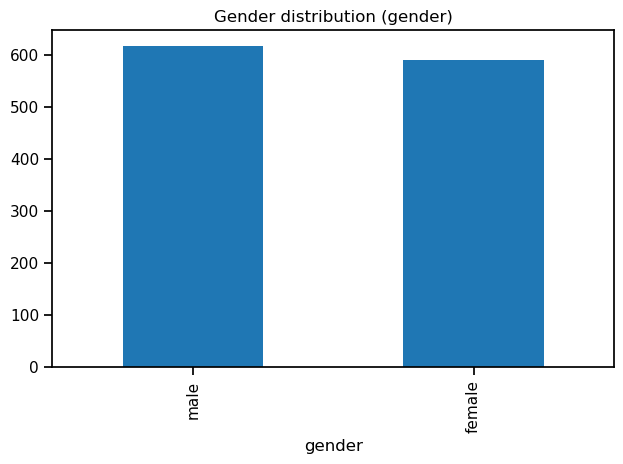

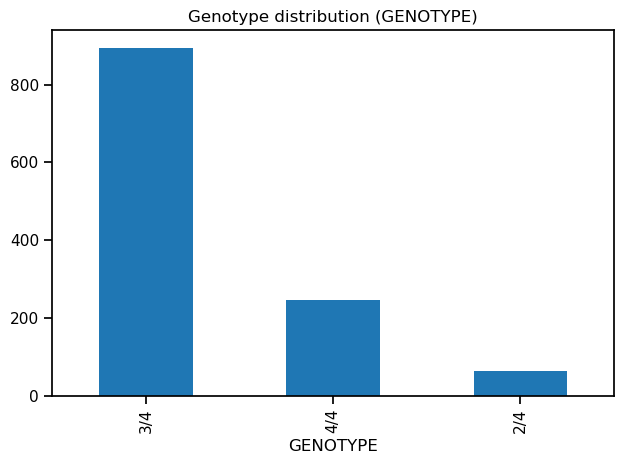

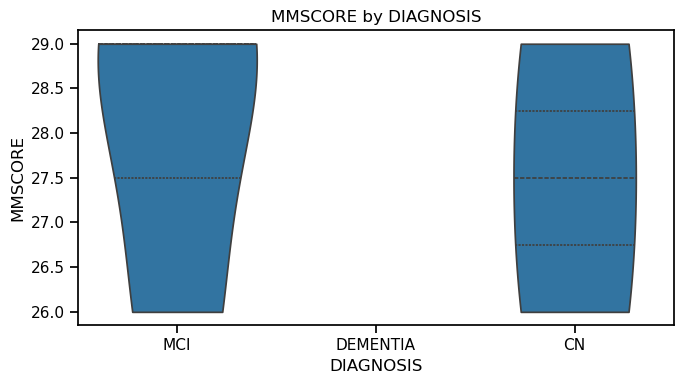

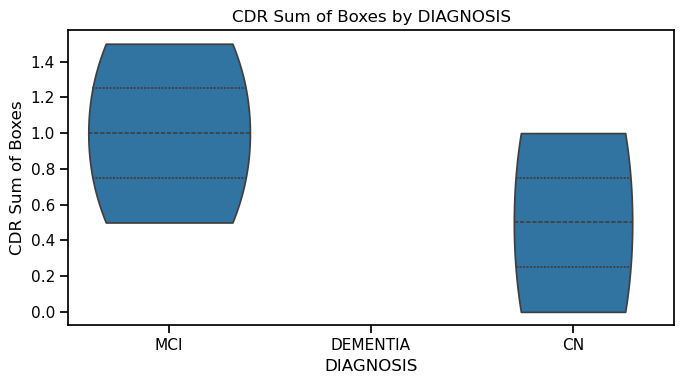

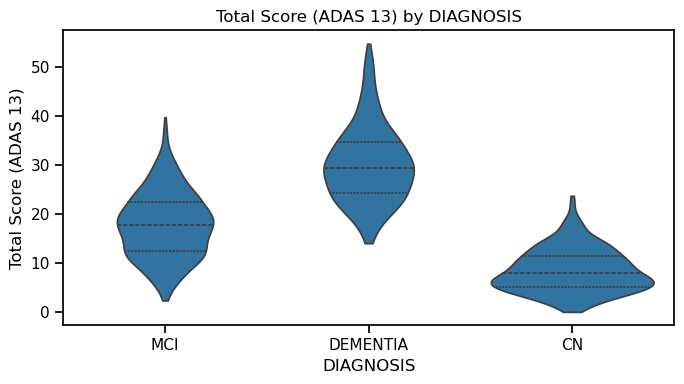

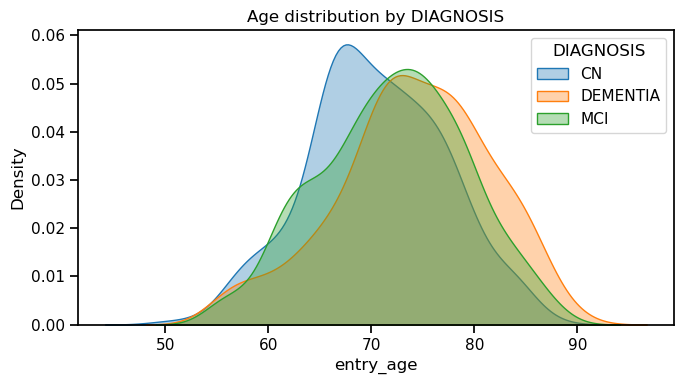

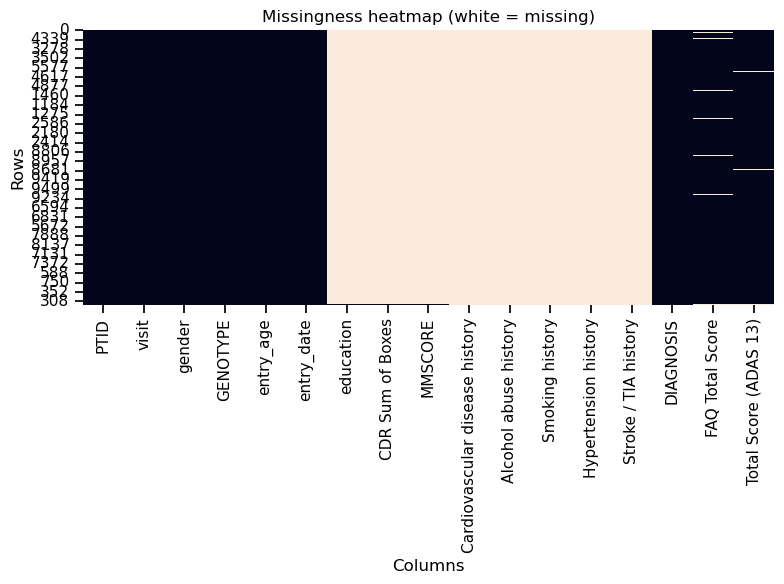

EDA complete. Plots saved to: /Users/madhurabn/Desktop/adni/data/processed/plots


In [4]:
#  EDA
import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path


try:
    import seaborn as sns
    sns.set_context("notebook")
    _HAS_SNS = True
except Exception:
    _HAS_SNS = False


if 'baseline' not in globals():
    raise RuntimeError("Expected 'baseline' DataFrame to exist. Run the baseline-filter cell first.")

# Ensure plots directory exists
plots_dir = globals().get('plots_dir', Path("./data/processed/plots"))
Path(plots_dir).mkdir(parents=True, exist_ok=True)

# Plots
SHOW_PLOTS = globals().get('SHOW_PLOTS', True)


def safe_filename(name: str) -> str:
    return re.sub(r'[\\/*?:"<>| ]+', "_", str(name))


def _find_contains_col(df, token_list):
    for col in df.columns:
        lc = col.lower()
        for tok in token_list:
            if tok in lc:
                return col
    return None


find_col = globals().get('find_contains_col', _find_contains_col)

#  token sets 
MMSE_TOKENS   = globals().get('MMSE_TOKENS',   ["mmscore", "mmse"])
CDRSB_TOKENS  = globals().get('CDRSB_TOKENS',  ["cdr sum of boxes", "cdrsb"])
FAQ_TOKENS    = globals().get('FAQ_TOKENS',    ["faq total", "faq total score", "faq"])
ADAS_TOKENS   = globals().get('ADAS_TOKENS',   ["adas13", "adas 13"])
COMORB_TOKENS = globals().get('COMORB_TOKENS', ["hypertension", "stroke", "smok", "diabet", "cardio", "t2dm"])

#  resolve key columns 
diag_col   = globals().get('diag_col', find_col(baseline, ["diagnosis", "diag"]))
age_col    = globals().get('age_col',  find_col(baseline, ["entry_age", "age", "ptage", "baselineage"]))
gender_col = globals().get('gender_col', find_col(baseline, ["gender", "sex"]))

mmse_col  = find_col(baseline, MMSE_TOKENS)
cdrsb_col = find_col(baseline, CDRSB_TOKENS)
adas_col  = find_col(baseline, ADAS_TOKENS)
faq_col   = find_col(baseline, FAQ_TOKENS)
edu_col   = find_col(baseline, ["education", "years_education", "educ"])

#  bar graph
def _bar_counts(series, title, out_png):
    plt.figure()
    series.value_counts(dropna=False).plot(kind="bar", title=title)
    plt.tight_layout()
    plt.savefig(out_png, dpi=150)
    if SHOW_PLOTS: plt.show()
    plt.close()

#   Age histogram
if age_col:
    ser = pd.to_numeric(baseline[age_col], errors="coerce").dropna()
    if not ser.empty:
        plt.figure()
        ser.plot(kind="hist", bins=30, title=f"Histogram of {age_col}")
        plt.xlabel(age_col); plt.tight_layout()
        plt.savefig(plots_dir / "age_hist.png", dpi=150)
        if SHOW_PLOTS: plt.show()
        plt.close()

#  Gender distribution
if gender_col:
    _bar_counts(baseline[gender_col], f"Gender distribution ({gender_col})", plots_dir / "gender_bar.png")

#  Genotype distribution (APOE)
geno_col = find_col(baseline, ["genotype", "apoe"])
if geno_col:
    _bar_counts(baseline[geno_col], f"Genotype distribution ({geno_col})", plots_dir / "genotype_bar.png")

#  plots: MMSE, CDRSB, ADAS13 by Diagnosis
if _HAS_SNS:
    for col, fname in [(mmse_col, "violin_mmse_by_diag.png"),
                       (cdrsb_col, "violin_cdrsb_by_diag.png"),
                       (adas_col, "violin_adas13_by_diag.png")]:
        if col and diag_col and baseline[col].notna().any():
            plt.figure(figsize=(7,4))
            sns.violinplot(data=baseline, x=diag_col, y=col, inner="quartile", cut=0)
            plt.title(f"{col} by {diag_col}")
            plt.tight_layout()
            plt.savefig(plots_dir / fname, dpi=150)
            if SHOW_PLOTS: plt.show()
            plt.close()
else:
    
    for col, fname in [(mmse_col, "box_mmse_by_diag.png"),
                       (cdrsb_col, "box_cdrsb_by_diag.png"),
                       (adas_col, "box_adas13_by_diag.png")]:
        if col and diag_col and baseline[col].notna().any():
            plt.figure(figsize=(7,4))
            groups, labels = [], []
            for dlab, sub in baseline.groupby(diag_col):
                vals = pd.to_numeric(sub[col], errors="coerce").dropna().values
                if len(vals): groups.append(vals); labels.append(str(dlab))
            if groups:
                plt.boxplot(groups, labels=labels)
                plt.title(f"{col} by {diag_col}")
                plt.tight_layout()
                plt.savefig(plots_dir / fname, dpi=150)
                if SHOW_PLOTS: plt.show()
                plt.close()


#  Density (KDE): Age by Diagnosis
if _HAS_SNS and age_col and diag_col:
    plt.figure(figsize=(7,4))
    for grp, sub in baseline.groupby(diag_col):
        vals = pd.to_numeric(sub[age_col], errors="coerce").dropna()
        if len(vals) > 1:
            sns.kdeplot(vals, fill=True, alpha=0.35, label=str(grp))
    plt.title(f"Age distribution by {diag_col}")
    plt.xlabel(age_col); plt.legend(title=diag_col)
    plt.tight_layout()
    plt.savefig(plots_dir / "kde_age_by_diag.png", dpi=150)
    if SHOW_PLOTS: plt.show()
    plt.close()


#  Missingness heatmap
plt.figure(figsize=(8, 6))
msk = baseline.isna()
if _HAS_SNS:
    sns.heatmap(msk, cbar=False)
    plt.title("Missingness heatmap (white = missing)")
else:
    plt.imshow(msk.values, aspect="auto", interpolation="nearest")
    plt.title("Missingness heatmap (white = missing)")
plt.xlabel("Columns"); plt.ylabel("Rows")
plt.tight_layout()
plt.savefig(plots_dir / "missingness_heatmap.png", dpi=150)
if SHOW_PLOTS: plt.show()
plt.close()

print("EDA complete. Plots saved to:", plots_dir)


 Hybrid Imputation Summary (MICE continuous + IQR clip + Mode categorical) 
Rows: 1205  Columns: 17
Missing before: 9653
Missing after : 0


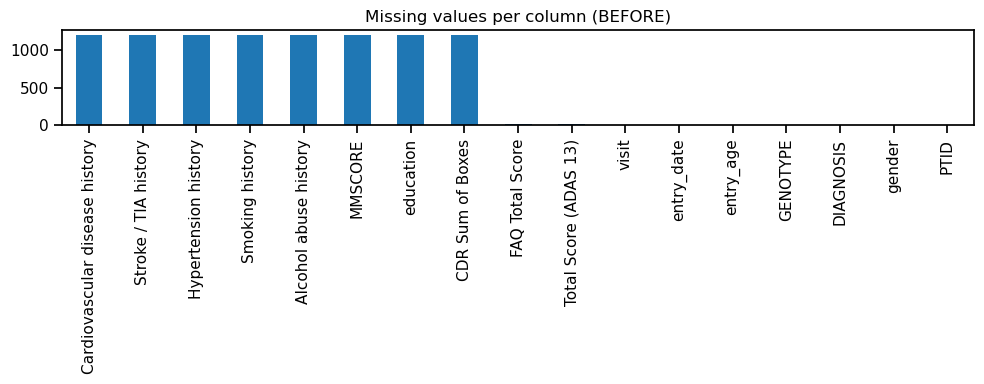

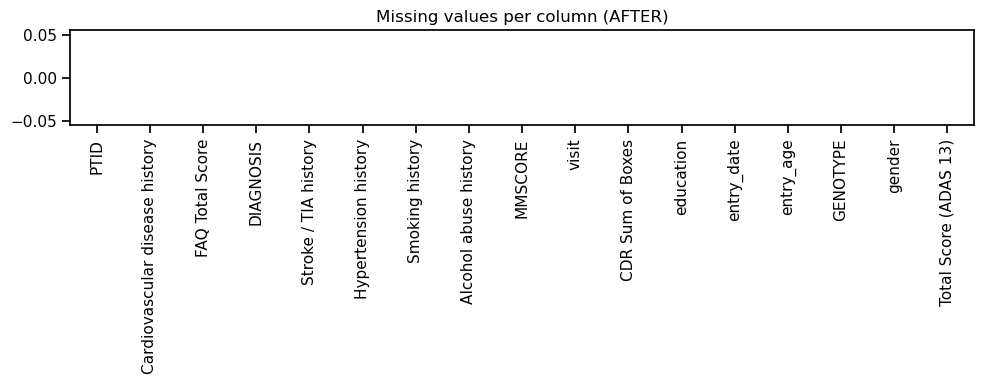

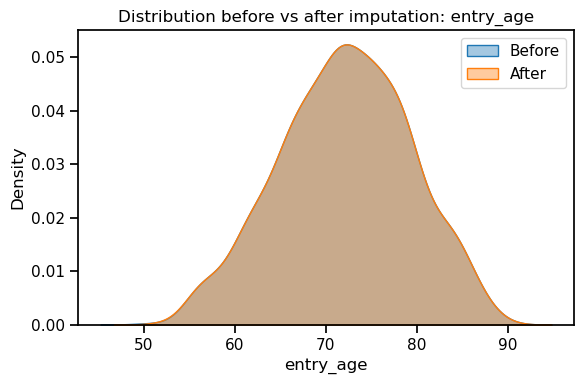

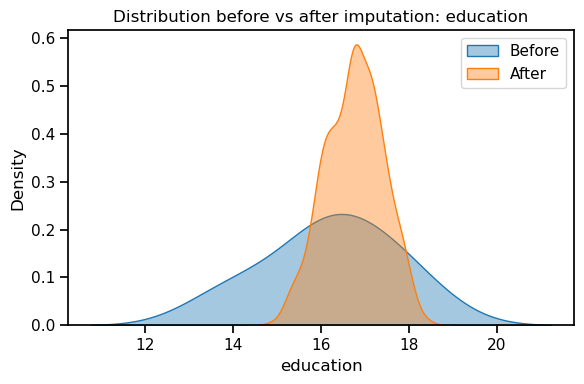

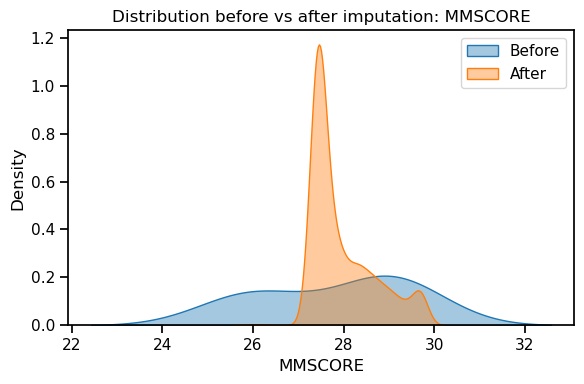

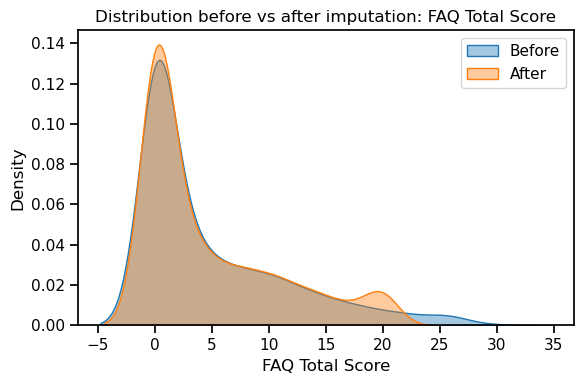

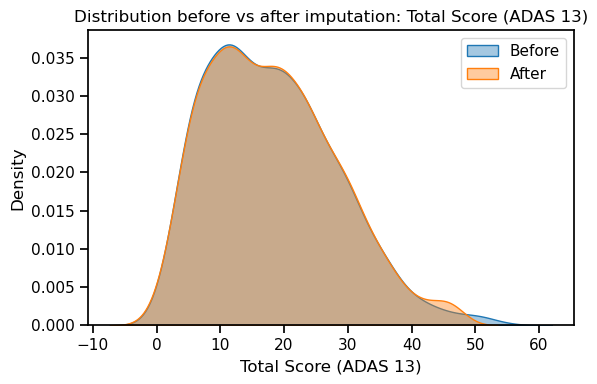

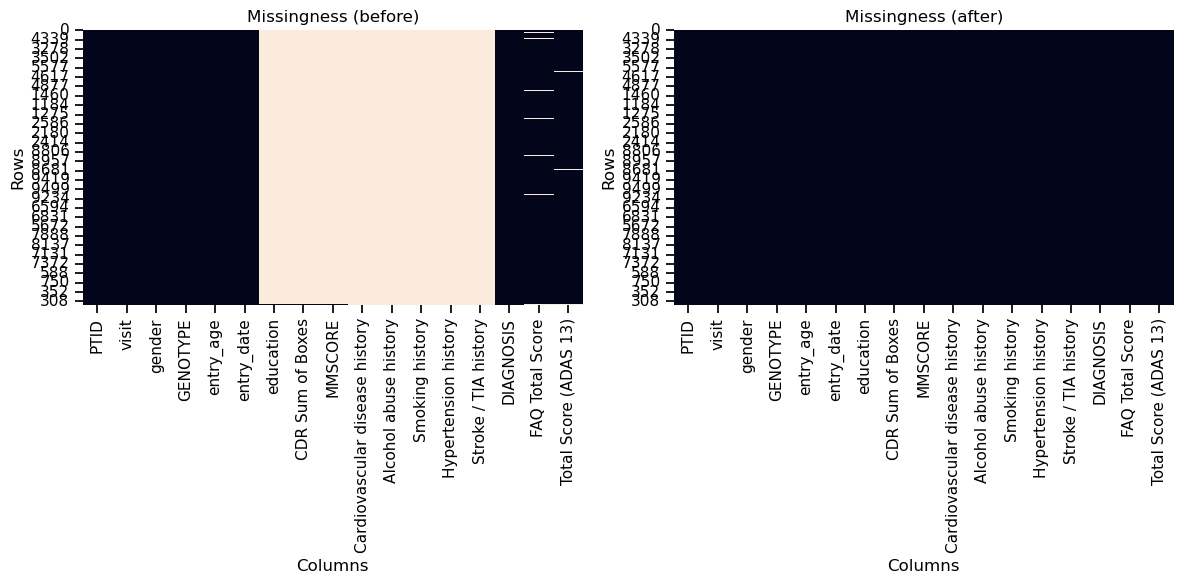


Saved final imputed file: /Users/madhurabn/Desktop/adni/data/processed/clinical_cognitive_demographic__imputed.xlsx
Saved summary plots in: /Users/madhurabn/Desktop/adni/data/processed/plots


In [5]:
# Hybrid imputation: MICE (continuous) + Mode (categorical/binary) + IQR clipping

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

try:
    import seaborn as sns
    _HAS_SNS = True
except Exception:
    _HAS_SNS = False

from sklearn.experimental import enable_iterative_imputer  # noqa: F401
from sklearn.impute import IterativeImputer, SimpleImputer

#  Helper to make safe filenames
def safe_filename(name: str) -> str:
    return re.sub(r'[\\/*?:"<>| ]+', "_", str(name))

#  prerequisites
if 'baseline' not in globals():
    raise RuntimeError("Expected 'baseline' to exist. Please run the baseline-filter cell first.")

ptid_key = globals().get('ptid_col', None)
diag_key = globals().get('diag_col', None)

df_before = baseline.copy()
df_after  = baseline.copy()

#  detect numeric vs categorical/binary
obj_like = df_after.select_dtypes(include=['object', 'category']).columns.tolist()
num_like = df_after.select_dtypes(include=[np.number]).columns.tolist()

def _is_binary_series(s: pd.Series) -> bool:
    vals = s.dropna().unique()
    if len(vals) == 0: return False
    if pd.api.types.is_numeric_dtype(s):
        return set(pd.Series(vals).astype(float).astype(int)).issubset({0,1})
    low = pd.Series(vals).astype(str).str.strip().str.lower()
    return low.isin({"yes","no","y","n","true","false","0","1"}).all()

binary_cols_num = [c for c in num_like if c not in {ptid_key, diag_key} and _is_binary_series(df_after[c])]
cont_cols = [c for c in num_like if c not in {ptid_key, diag_key} and c not in binary_cols_num]
cat_cols = [c for c in obj_like if c not in {ptid_key, diag_key}]

#  impute categorical/binary with most_frequent 
cat_bin_to_impute = [c for c in cat_cols + binary_cols_num if df_after[c].isna().any()]
if cat_bin_to_impute:
    mode_imp = SimpleImputer(strategy="most_frequent")
    df_after[cat_bin_to_impute] = mode_imp.fit_transform(df_after[cat_bin_to_impute])

#  impute continuous with MICE
if cont_cols:
    mice = IterativeImputer(
        random_state=42,
        sample_posterior=False,
        max_iter=10,
        initial_strategy="median"
    )
    df_after[cont_cols] = mice.fit_transform(df_after[cont_cols])

    #  IQR clipping to keep values clinically plausible 
    for c in cont_cols:
        series = pd.to_numeric(df_after[c], errors="coerce")
        q1 = series.quantile(0.25)
        q3 = series.quantile(0.75)
        if pd.isna(q1) or pd.isna(q3):
            continue
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr

        # Non-negative hint for biomarker/score-like columns
        nonneg_hint = any(kw in c.lower() for kw in [
            "tau","beta","abeta","aβ","score","mmse","cdr","adas","faq","age","csf","pg_ml"
        ])
        clipped = series.clip(lower=lower, upper=upper)
        if nonneg_hint:
            clipped = clipped.clip(lower=0)
        df_after[c] = clipped

#  enforce binary back to 0/1
for c in binary_cols_num:
    df_after[c] = pd.to_numeric(df_after[c], errors="coerce").round().clip(0,1).astype("Int64").astype(int)

#  save output
outdir_safe    = globals().get('outdir', Path("./data/processed"))
plots_dir_safe = globals().get('plots_dir', outdir_safe / "plots")
outdir_safe.mkdir(parents=True, exist_ok=True)
plots_dir_safe.mkdir(parents=True, exist_ok=True)

out_path = outdir_safe / "clinical_cognitive_demographic__imputed.xlsx"
df_after.to_excel(out_path, index=False)

#  summary
print(" Hybrid Imputation Summary (MICE continuous + IQR clip + Mode categorical) ")
print("Rows:", df_after.shape[0], " Columns:", df_after.shape[1])
print("Missing before:", int(df_before.isna().sum().sum()))
print("Missing after :", int(df_after.isna().sum().sum()))

#  plots
# Missingness bar before/after
for tag, df in [("before", df_before), ("after", df_after)]:
    plt.figure(figsize=(10,4))
    df.isna().sum().sort_values(ascending=False).plot(kind="bar", title=f"Missing values per column ({tag.upper()})")
    plt.tight_layout(); plt.savefig(plots_dir_safe / f"missing_bar_{tag}.png", dpi=150)
    plt.show()

# Distribution comparisons (first 5 continuous cols)
for c in cont_cols[:5]:
    plt.figure(figsize=(6,4))
    if _HAS_SNS:
        sns.kdeplot(df_before[c], label="Before", fill=True, alpha=0.4)
        sns.kdeplot(df_after[c],  label="After",  fill=True, alpha=0.4)
    else:
        plt.hist(df_before[c].dropna(), bins=30, alpha=0.5, label="Before", density=True)
        plt.hist(df_after[c].dropna(),  bins=30, alpha=0.5, label="After",  density=True)
    plt.title(f"Distribution before vs after imputation: {c}")
    plt.legend(); plt.tight_layout()
    fname = f"dist_compare_{safe_filename(c)}.png"
    plt.savefig(plots_dir_safe / fname, dpi=150)
    plt.show()

# Missingness heatmaps
fig, axes = plt.subplots(1, 2, figsize=(12,6))
if _HAS_SNS:
    sns.heatmap(df_before.isna(), cbar=False, ax=axes[0]); axes[0].set_title("Missingness (before)")
    sns.heatmap(df_after.isna(),  cbar=False, ax=axes[1]); axes[1].set_title("Missingness (after)")
else:
    axes[0].imshow(df_before.isna(), aspect="auto"); axes[0].set_title("Missingness (before)")
    axes[1].imshow(df_after.isna(),  aspect="auto"); axes[1].set_title("Missingness (after)")
for ax in axes: ax.set_xlabel("Columns"); ax.set_ylabel("Rows")
plt.tight_layout(); plt.savefig(plots_dir_safe / "missingness_heatmaps.png", dpi=150)
plt.show()

print("\nSaved final imputed file:", out_path)
print("Saved summary plots in:", plots_dir_safe)
